Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


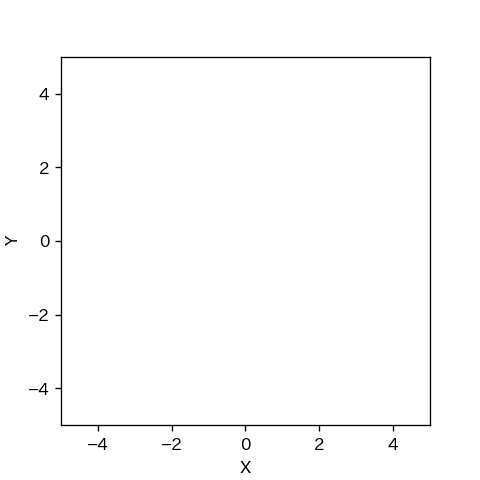

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


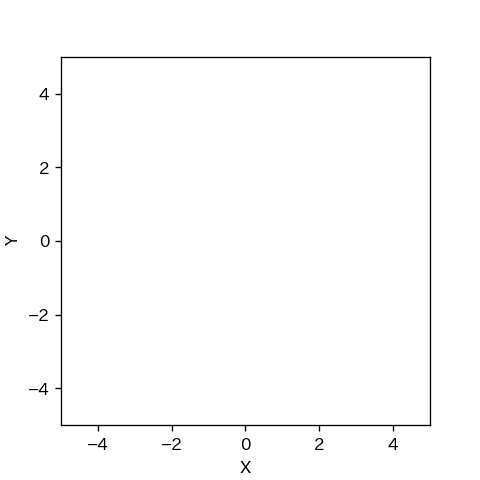

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_phantom(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [ 0.0287805  -0.28534381  6.39261125] 推定値: [-0.05405565 -0.69864364  6.49953258] 誤差: 0.42151936968490383
1
1 真値: [-0.31448711 -0.11809593  6.14123502] 推定値: [-0.20605024 -1.20384317  6.29488464] 誤差: 1.0911487600106526
2 真値: [-1.02378361  0.5890273   5.20374615] 推定値: [-1.36515506  0.61329768  5.26518264] 誤差: 0.34223313272688516
2
3 真値: [-0.7439622   0.30067201  5.50599479] 推定値: [-0.92074794 -0.6281938   5.68976298] 誤差: 0.9455394688317041
3
4 真値: [-1.05201151  1.00858158  5.08910263] 推定値: [-1.14454894  0.81433896  5.13243955] 誤差: 0.21515895340522995
4
5 真値: [-1.55939756  1.21128688  5.06194028] 推定値: [-1.24427334  1.21102116  4.97253092] 誤差: 0.3151243362086329
5
6 真値: [-1.13121025  1.06038427  4.83560902] 推定値: [-1.26183752  0.88595763  4.82316492] 誤差: 0.2179177302285024
6
7 真値: [0.68098609 0.68382771 7.26657363] 推定値: [0.34622128 0.54810377 7.23929405] 誤差: 0.36123187473416585
7
8 真値: [-1.74128406  2.67391836  3.78373869] 推定値: [-1.56218141  2.43285149  3.66574825] 誤差: 0.300318167181314

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-0.89195419  1.85117485  4.2217643 ] 推定値: [-0.62241075  1.75503324  4.14813286] 誤差: 0.2861763018818977
18
21 真値: [-0.97177906  0.76377479  4.94390827] 推定値: [-1.8971051   0.32545758  4.96975025] 誤差: 1.023889768557871
22 真値: [-0.97737909  1.26633433  4.58334011] 推定値: [-1.17202044  1.61326498  4.87548498] 誤差: 0.3978016252451364
19
23 真値: [-0.76444604  0.55942373  4.99136864] 推定値: [-1.50957249 -0.96119008  5.36763813] 誤差: 1.693363463335896
24 真値: [-1.2574494   2.29780936  4.08294848] 推定値: [-1.28262628  1.99176493  4.02171037] 誤差: 0.3070782824691502
20
25 真値: [-1.66703089  1.58800298  4.56215262] 推定値: [-1.41349043  1.82193554  4.57029526] 誤差: 0.3449742096507596
21
26 真値: [-0.351469   -0.40178522  5.85718721] 推定値: [ 0.23091347 -0.30676773  5.96554029] 誤差: 0.5900827574962421
22
27 真値: [-1.32080522  1.73831486  4.58042917] 推定値: [-1.46762215  1.68307002  4.59980017] 誤差: 0.15686683525385647
23
28 真値: [-0.88465603  0.14457826  5.64444987] 推定値: [-1.54696386  0.02515897  5.73706243] 誤差: 0.6